In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from kitti_object import *


In [4]:
from xvfbwrapper import Xvfb
vdisplay = Xvfb(width=1920, height=1080)
vdisplay.start()
from mayavi import mlab
mlab.init_notebook('ipy') # do not use 'x3d' backend which leads to color missing

/root/miniconda3/envs/kitti_vis/lib/python3.8/site-packages/traits/etsconfig/etsconfig.py:412: UserWarning: Environment variable "HOME" not set, setting home directory to /tmp
  warn(


Notebook initialized with ipy backend.


In [5]:
dataset = kitti_object('../data/kitti/psedo/', 'training')

data_idx = 22
objects = dataset.get_label_objects(data_idx)
pc_velo = dataset.get_lidar(data_idx)
calib = dataset.get_calibration(data_idx)
img = dataset.get_image(data_idx)
img_height, img_width, _ = img.shape

fig_3d = mlab.figure(bgcolor=(0, 0, 0), size=(800, 450))
show_lidar_with_depth(pc_velo, objects, calib, fig_3d, True, img_width, img_height)
# plt.imshow(fig_3d)

../data/kitti/psedo/ training
../data/kitti/psedo/training/velodyne/000022.bin
('All point num: ', 307292)
('FOV point num: ', (307288, 4))
pc_velo (307288, 4)
==================== (307288, 4)
box3d_pts_3d_velo:
[[34.01029627 20.12021527 -2.1573826 ]
 [34.14519231 18.42565612 -2.17387846]
 [30.01847311 18.09760067 -2.22047138]
 [29.88357707 19.79215983 -2.20397553]
 [33.99545811 20.10521247 -0.73753929]
 [34.13035415 18.41065331 -0.75403515]
 [30.00363495 18.08259787 -0.80062808]
 [29.86873891 19.77715702 -0.78413222]]
box3d_pts_3d_velo:
[[33.89478941 22.81441106 -2.17012585]
 [34.01342731 21.10861415 -2.18691036]
 [29.91355545 20.82391998 -2.23276454]
 [29.79491755 22.52971689 -2.21598003]
 [33.87890631 22.79835172 -0.65029358]
 [33.99754421 21.09255481 -0.66707809]
 [29.89767235 20.80786064 -0.71293227]
 [29.77903445 22.51365755 -0.69614776]]


In [6]:
import matplotlib.pyplot as plt

def show_lidar_on_image(pc_velo, img, calib, img_width, img_height):
    """ Project LiDAR points to image """
    img =  np.copy(img)
    imgfov_pc_velo, pts_2d, fov_inds = get_lidar_in_image_fov(
        pc_velo, calib, 0, 0, img_width, img_height, True
    )
    imgfov_pts_2d = pts_2d[fov_inds, :]
    imgfov_pc_rect = calib.project_velo_to_rect(imgfov_pc_velo)

    max_num_color = 640.0 / imgfov_pc_rect[:,2].min()
    cmap = plt.cm.get_cmap("hsv", max_num_color)
    cmap = np.array([cmap(i) for i in range(512)])[:, :3] * max_num_color

    for i in range(imgfov_pts_2d.shape[0]):
        depth = imgfov_pc_rect[i, 2]
        color = cmap[int(640.0 / depth), :]
        cv2.circle(
            img,
            (int(np.round(imgfov_pts_2d[i, 0])), int(np.round(imgfov_pts_2d[i, 1]))),
            2,
            color=tuple(color),
            thickness=-1,
        )
    cv2.imshow("projection", img)
    return img



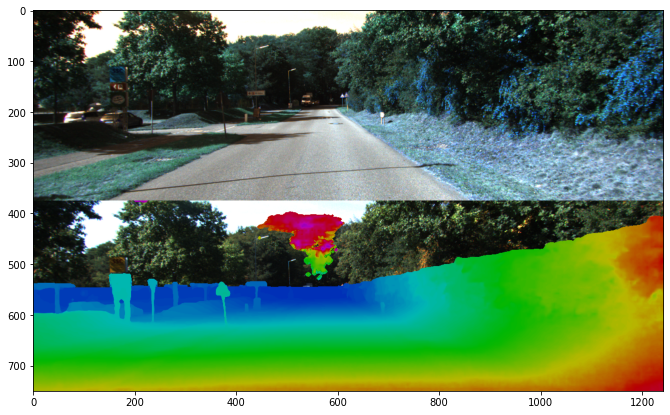

In [7]:
img_lidar = show_lidar_on_image(pc_velo[:, :3], img, calib, img_width, img_height)
img_lidar = cv2.cvtColor(img_lidar, cv2.COLOR_BGR2RGB)

fig_lidar = plt.figure(figsize=(14, 7))
ax_lidar = fig_lidar.subplots()
img_img_lidar = np.concatenate([img, img_lidar], 0)
ax_lidar.imshow(img_img_lidar)
plt.show()

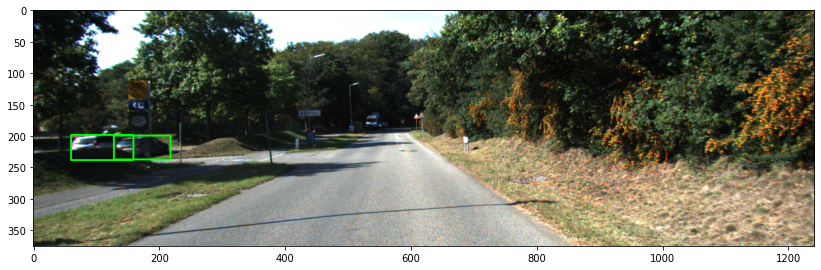

In [8]:
img_bbox2d, img_bbox3d = show_image_with_boxes(img, objects, calib)
img_bbox2d = cv2.cvtColor(img_bbox2d, cv2.COLOR_BGR2RGB)

fig_bbox2d = plt.figure(figsize=(14, 7))
ax_bbox2d = fig_bbox2d.subplots()
ax_bbox2d.imshow(img_bbox2d)
plt.show()

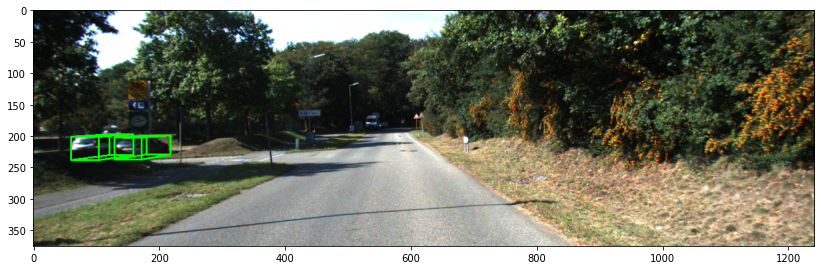

In [9]:
img_bbox3d = cv2.cvtColor(img_bbox3d, cv2.COLOR_BGR2RGB)

fig_bbox3d = plt.figure(figsize=(14, 7))
ax_bbox3d = fig_bbox3d.subplots()
ax_bbox3d.imshow(img_bbox3d)
plt.show()

top_image: (500, 300, 3)


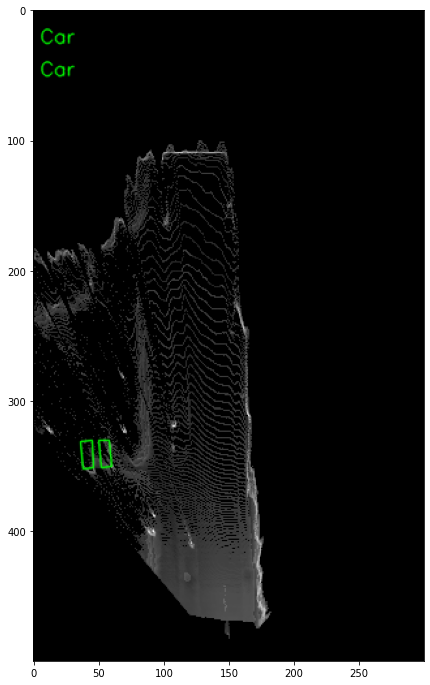

In [10]:
img_bev = show_lidar_topview_with_boxes(pc_velo, objects, calib)

fig_bev = plt.figure(figsize=(7, 14))
ax_bev = fig_bev.subplots()
ax_bev.imshow(img_bev)
plt.show()